In [58]:
import numpy as np
# Load training data
data = np.load('emnist-byclass-train.npz')
train_labels = data['training_labels']
train_data = data['training_images']

# Load testing data
test_data = np.load('emnist-byclass-test.npz')['testing_images']

In [59]:
import torch

# Shuffle the data and labels
indices = np.random.permutation(len(train_data))
train_data = train_data[indices]
train_labels = train_labels[indices]

# Define the percentage of data to be used for validation
val_percent = 0.2

# Calculate the number of validation samples
val_size = int(len(train_data) * val_percent)

# Split the data and labels into training and validation sets
val_data = train_data[:val_size]
train_data = train_data[val_size:]
val_labels = train_labels[:val_size]
train_labels = train_labels[val_size:]

# Convert the data and labels to PyTorch tensors
train_data = torch.from_numpy(train_data).float()
val_data = torch.from_numpy(val_data).float()
train_labels = torch.from_numpy(train_labels).long()
val_labels = torch.from_numpy(val_labels).long()

torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])


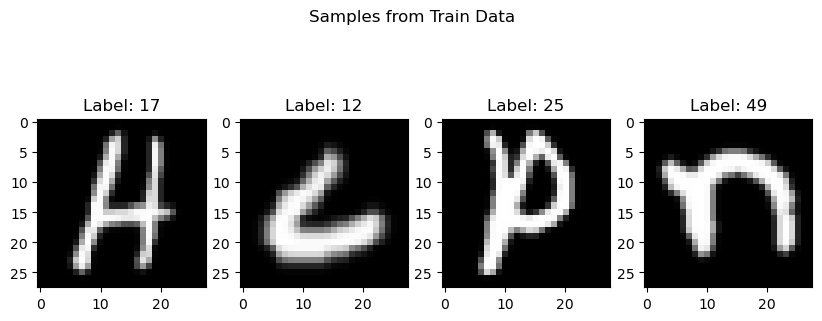

In [89]:
import matplotlib.pyplot as plt

indices = [0, 1, 2, 25]

# create a figure with subplots
fig, axs = plt.subplots(1, len(indices), figsize=(10, 4))
fig.suptitle('Samples from Train Data')

# plot each sample
for i, idx in enumerate(indices):
    axs[i].imshow(train_data[idx,:,:,0].reshape(28,28), cmap='gray')
    axs[i].set_title('Label: {}'.format(int(train_labels[idx])))
    print(train_data[idx].shape)
plt.show()

In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [70]:
import os
#import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [71]:
number_of_symbols = int(max(train_labels))+1

In [72]:
print(number_of_symbols)

62


In [260]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class SymbolRecognizer(nn.Module):
    def __init__(self):
        super(SymbolRecognizer, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(9216, 1024) 
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, number_of_symbols)
        self.Leaky_ReLu = nn.LeakyReLU()
        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2) #just to fit data from dataset to layers

        x = self.conv1(x)
        x = F.leaky_relu(x)

        x = self.conv2(x)
        x = F.leaky_relu(x)

        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.Leaky_ReLu(x)
        x = self.fc3(x)
        x = self.Leaky_ReLu(x)
        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output
    
    # Instantiate the neural network
model = SymbolRecognizer()
print(model)

SymbolRecognizer(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=62, bias=True)
  (Leaky_ReLu): LeakyReLU(negative_slope=0.01)
)


In [263]:
from torch.utils.data import TensorDataset, DataLoader
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Convert the data and labels to PyTorch datasets
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
# Define batch size for training and validation dataloaders
batch_size = 64
# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=10)
save_every = 2
train_iterations = 24


In [264]:
# Train the neural network
for epoch in range(train_iterations):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        print (f'{i}', end = ' \r'),
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"\nEpoch {epoch} loss: {running_loss/len(train_loader)}")
    if (epoch % save_every == 0):
        model_file_name = f'model_weights_{epoch}.pth'
        print(f'Saving model as {model_file_name}')
        torch.save(model, model_file_name)
torch.save(model, f'model_weights_{train_iterations}.pth')

8724 
Epoch 0 loss: 0.5572591660613658
Saving model as model_weights_0.pth
8724 
Epoch 1 loss: 0.42360185039846127
8724 
Epoch 2 loss: 0.39611035861224364
Saving model as model_weights_2.pth
8724 
Epoch 3 loss: 0.3787318782666351
8724 
Epoch 4 loss: 0.36670790167199846
Saving model as model_weights_4.pth
8724 
Epoch 5 loss: 0.3569656314685898
8724 
Epoch 6 loss: 0.34911873823336
Saving model as model_weights_6.pth
8724 
Epoch 7 loss: 0.34293528306023097
8724 
Epoch 8 loss: 0.33724939336856147
Saving model as model_weights_8.pth
8724 
Epoch 9 loss: 0.33157135360818196
8724 
Epoch 10 loss: 0.32654945763441756
Saving model as model_weights_10.pth
8724 
Epoch 11 loss: 0.3232742516512857
8724 
Epoch 12 loss: 0.3194895427975067
Saving model as model_weights_12.pth
8724 
Epoch 13 loss: 0.31485134865416153
8724 
Epoch 14 loss: 0.3109959363604343
Saving model as model_weights_14.pth
8724 
Epoch 15 loss: 0.3083239507137192
8724 
Epoch 16 loss: 0.3060332304948039
Saving model as model_weights_16.

In [270]:
# Set the model to evaluation mode
model.eval()

# Initialize the total loss and accuracy
total_loss = 0
total_correct = 0
total_samples = 0

# Disable gradient calculation
with torch.no_grad():
    # Loop over the validation set
    for batch_data, batch_labels in val_loader:
        # Move the data and labels to the device
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_data)
        batch_labels = torch.squeeze(batch_labels)
        # Calculate the loss
        loss = criterion(outputs, batch_labels)

        # Accumulate the loss
        total_loss += loss.item() * batch_data.size(0)

        # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)

        # Count the number of correct predictions
        total_correct += (predicted == batch_labels).sum().item()

        # Increment the total number of samples
        total_samples += batch_data.size(0)

# Calculate the average loss and accuracy over the validation set
average_loss = total_loss / total_samples
accuracy = total_correct / total_samples

# Print the results
print('Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(average_loss, accuracy * 100))

Validation Loss: 0.3156, Validation Accuracy: 87.97%


In [254]:
def evaluate(model_file, val_loader):
    # Load the neural network from file
    model = torch.load(model_file)
    print('Testing model ' + model_file)
    # Get the name of the model
    model_name = model_file.split("/")[-1]
    
    # Evaluate the neural network on the testing set
    total_loss = 0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
            # Loop over the validation set
        for batch_data, batch_labels in val_loader:
            # Move the data and labels to the device
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_data)
            batch_labels = torch.squeeze(batch_labels)
            # Calculate the loss
            loss = criterion(outputs, batch_labels)

            # Accumulate the loss
            total_loss += loss.item() * batch_data.size(0)

            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)

            # Count the number of correct predictions
            total_correct += (predicted == batch_labels).sum().item()

            # Increment the total number of samples
            total_samples += batch_data.size(0)

# Calculate the average loss and accuracy over the validation set
    average_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

# Print the results
    print('Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(average_loss, accuracy * 100))
    return accuracy

In [272]:
for i in range(train_iterations):
    if (i % save_every == 0):
        #print(i)
        evaluate(f'model_weights_{i}.pth',val_loader)

Testing model model_weights_0.pth
Validation Loss: 0.4498, Validation Accuracy: 84.04%
Testing model model_weights_2.pth
Validation Loss: 0.4191, Validation Accuracy: 85.08%
Testing model model_weights_4.pth
Validation Loss: 0.4180, Validation Accuracy: 85.43%
Testing model model_weights_6.pth
Validation Loss: 0.4220, Validation Accuracy: 85.40%
Testing model model_weights_8.pth
Validation Loss: 0.4223, Validation Accuracy: 85.48%
Testing model model_weights_10.pth
Validation Loss: 0.4330, Validation Accuracy: 85.30%
Testing model model_weights_12.pth
Validation Loss: 0.4415, Validation Accuracy: 85.14%
Testing model model_weights_14.pth
Validation Loss: 0.4605, Validation Accuracy: 85.14%
Testing model model_weights_16.pth
Validation Loss: 0.4678, Validation Accuracy: 85.37%
Testing model model_weights_18.pth
Validation Loss: 0.4552, Validation Accuracy: 85.12%
Testing model model_weights_20.pth
Validation Loss: 0.4985, Validation Accuracy: 85.02%
Testing model model_weights_22.pth
Va

In [225]:
submission_data = torch.from_numpy(test_data)

In [267]:
model = torch.load("model_weights_8.pth")

In [268]:
import pandas as pd


In [269]:
all_predictions = []
submission_loader = DataLoader(submission_data, batch_size=1, shuffle=False,num_workers=8)
with torch.no_grad():
    for i, (inputs) in enumerate(submission_loader):
        outputs = model(inputs)
        _,predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.numpy())
# Save the predictions to a new CSV file
image_ids = [i for i in range(len(all_predictions))]
df = pd.DataFrame({'Id': image_ids, 'Category': all_predictions})
df.to_csv('My_model_predictions.csv', index=False)